# Fake News

### Data Preparation

In [1]:
## Import required libraries
import pandas as pd
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval
from hyperopt.pyll.base import scope
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
## Import Data
df = pd.read_csv('news.csv')
print(df.shape)
df.head()

(6335, 4)


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
## Renaming unnamed column
df = df.rename(columns={'Unnamed: 0': 'id'})
df.head()

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
## Converting label into a binary variable
df['label'] = df['label'].replace({'REAL': 0, 'FAKE': 1})
df.head()

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


In [5]:
## Checking balance of the data
print('Fake News articles:')
print(df['label'].sum())
print('Real News articles:')
print((df['label'] == 0).sum())

Fake News articles:
3164
Real News articles:
3171


In [6]:
## Converting text to lower case
df['text'] = df['text'].str.lower()

In [7]:
## Convert to dictionary
news = df.to_dict('records')

## Print the first news story
print(news[0]['text'])

daniel greenfield, a shillman journalism fellow at the freedom center, is a new york writer focusing on radical islam. 
in the final stretch of the election, hillary rodham clinton has gone to war with the fbi. 
the word “unprecedented” has been thrown around so often this election that it ought to be retired. but it’s still unprecedented for the nominee of a major political party to go war with the fbi. 
but that’s exactly what hillary and her people have done. coma patients just waking up now and watching an hour of cnn from their hospital beds would assume that fbi director james comey is hillary’s opponent in this election. 
the fbi is under attack by everyone from obama to cnn. hillary’s people have circulated a letter attacking comey. there are currently more media hit pieces lambasting him than targeting trump. it wouldn’t be too surprising if the clintons or their allies were to start running attack ads against the fbi. 
the fbi’s leadership is being warned that the entire left

In [8]:
## Remove punctuation

def remove_punctuation(text):
    '''
    This function takes a text string and removes punctuation.

    Parameters:
        text (str): Text to be processed
    
    Returns:
        str: Text string with punctuation removed
    '''
    # Create a translation table mapping every punctuation character to None
    # string.punctuation doesn't remove quotation marks so added this separately
    translator = str.maketrans('', '', string.punctuation + '“”‘’')

    # Use this table to remove all punctuation from the text
    return text.translate(translator)

texts = [remove_punctuation(news_item['text']) for news_item in news]

In [9]:
## Tokenise i.e separate each word

from nltk.tokenize import word_tokenize

tokens = [word_tokenize(text) for text in texts]

In [10]:
## Print individual words (tokens) of first news story
print(tokens[0])

['daniel', 'greenfield', 'a', 'shillman', 'journalism', 'fellow', 'at', 'the', 'freedom', 'center', 'is', 'a', 'new', 'york', 'writer', 'focusing', 'on', 'radical', 'islam', 'in', 'the', 'final', 'stretch', 'of', 'the', 'election', 'hillary', 'rodham', 'clinton', 'has', 'gone', 'to', 'war', 'with', 'the', 'fbi', 'the', 'word', 'unprecedented', 'has', 'been', 'thrown', 'around', 'so', 'often', 'this', 'election', 'that', 'it', 'ought', 'to', 'be', 'retired', 'but', 'its', 'still', 'unprecedented', 'for', 'the', 'nominee', 'of', 'a', 'major', 'political', 'party', 'to', 'go', 'war', 'with', 'the', 'fbi', 'but', 'thats', 'exactly', 'what', 'hillary', 'and', 'her', 'people', 'have', 'done', 'coma', 'patients', 'just', 'waking', 'up', 'now', 'and', 'watching', 'an', 'hour', 'of', 'cnn', 'from', 'their', 'hospital', 'beds', 'would', 'assume', 'that', 'fbi', 'director', 'james', 'comey', 'is', 'hillarys', 'opponent', 'in', 'this', 'election', 'the', 'fbi', 'is', 'under', 'attack', 'by', 'ever

In [11]:
## Remove stopwords

# Load common English stopwords
stops = stopwords.words('english')

# Define a function that removes stopwords
def remove_stops(text, stops):
    return [token for token in text if token not in set(stops)]

tokens = [remove_stops(article, stops) for article in tokens]

In [12]:
# create a list called texts
# Concatenate the individual tokens within each news story into a single string
texts = [' '.join(article) for article in tokens]

# Iterates over each row and extract the label: 1 for fake, 0 for real
fake = [row['label'] for row in news]

In [13]:
## Check it has worked
# Print text of first article as a list of words
print(texts[0])
# Show the labels for the first 10 stories
fake[0:10]

daniel greenfield shillman journalism fellow freedom center new york writer focusing radical islam final stretch election hillary rodham clinton gone war fbi word unprecedented thrown around often election ought retired still unprecedented nominee major political party go war fbi thats exactly hillary people done coma patients waking watching hour cnn hospital beds would assume fbi director james comey hillarys opponent election fbi attack everyone obama cnn hillarys people circulated letter attacking comey currently media hit pieces lambasting targeting trump wouldnt surprising clintons allies start running attack ads fbi fbis leadership warned entire leftwing establishment form lynch mob continue going hillary fbis credibility attacked media democrats preemptively head results investigation clinton foundation hillary clinton covert struggle fbi agents obamas doj people gone explosively public new york times compared comey j edgar hoover bizarre headline james comey role recalls hoove

[1, 1, 0, 1, 0, 1, 1, 0, 0, 0]

### Looking at the most frequent words

In [14]:
# Initialize vectorizer which will be used to convert text into a matrix of token counts.
vectorizer = CountVectorizer()

# Transform the text data 
CleanText = vectorizer.fit_transform(texts)
# converts the list of stories (texts) into a sparse matrix (X)
# each row of the matrix represents an individual news story
# each column represents a (unique) word in the corpus of news stories. 
# The values in the matrix indicate how many times each word appears in a particular news story.

In [15]:
print(CleanText.shape)
# 6335 news stories and 85,567 unique words (tokens) in the corpus

(6335, 85567)


In [16]:
# todense() converts the sparse matrix (where most of the counts are 0) to a dense one, where counts are non-zero values
# np.argmax finds the index with the highest value
word_freq = np.argmax(CleanText[0,:].todense())
print(f'The index for most frequent word is {word_freq}')
# vectorizer.get_feature_names_out() pulls that word out of the matrix
print(f'The most frequent word is {vectorizer.get_feature_names_out()[word_freq]}')

word_count = CleanText[0, word_freq]
print(f'It appears {word_count} times in the news stories\n')

# Sort words in order of frequency
words_sorted = np.argsort(-CleanText[0,:].todense())
print('The 10 most common words are:')
for word_freq in words_sorted[0,0:10].tolist()[0]:
    print(vectorizer.get_feature_names_out()[word_freq])

The index for most frequent word is 29227
The most frequent word is fbi
It appears 29 times in the news stories

The 10 most common words are:
fbi
clinton
hillary
comey
investigation
campaign
fear
time
people
war


In [17]:
# Put labels in form of numpy arrays
y = np.array(fake)
X = CleanText

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1234)

print("Training set size = %s" % y_train.shape)
print("Test set size = %s" % y_test.shape)

Training set size = 4434
Test set size = 1901


In [18]:
# Initialize the classifer
clf = MultinomialNB()

# Fit the model
clf_fit = clf.fit(X_train, y_train)

# We can print in-sample fit
print("In-sample accuracy = %s" % clf_fit.score(X, y))

In-sample accuracy = 0.9234411996842936


In [19]:
print('Probability of the first news article being fake:')
prob_ests = clf_fit.predict_proba(X)
print(prob_ests[0,:])

pred = clf_fit.predict(X)

print('\nClassification of the first news article:')
print(pred[0])

Probability of the first news article being fake:
[1.59690432e-61 1.00000000e+00]

Classification of the first news article:
1


#### Model Performance

In [20]:
y_predict = clf_fit.predict(X_test)

print('Naive Bayesian Model Performance:\n')
print(f'Precision = {precision_score(y_test, y_predict)}')
print(f'Recall = {recall_score(y_test, y_predict)}')
print(f'F1 score = {f1_score(y_test, y_predict)}')
print(f'Accuracy = {clf_fit.score(X_test, y_test)}')

Naive Bayesian Model Performance:

Precision = 0.9188275084554679
Recall = 0.8410732714138287
F1 score = 0.8782327586206896
Accuracy = 0.8811152025249869


##### Model Performance: K-fold Cross Validation

In [21]:
## Cross-validation score
# 10-fold cross-validation
# evaluating according to F1 score (mean of precision and recall)
np.mean(cross_val_score(clf, X, y, cv=10, scoring="f1"))

0.8848549678178486

### Logistic Regression

In [22]:
# Initialize the classifier
clf = LogisticRegression(solver='lbfgs', max_iter=500, random_state = 123)

In [23]:
logmodel = clf.fit(X_train, y_train)
y_pred = logmodel.predict(X_test)

print('Logisitc Regression Performance:\n')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')
print(f'F1 score = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {clf_fit.score(X_test, y_test)}')

Logisitc Regression Performance:

Precision = 0.9202453987730062
Recall = 0.9287925696594427
F1 score = 0.9244992295839752
Accuracy = 0.8811152025249869


#### Model Performance

In [24]:
np.mean(cross_val_score(clf, X, y, cv=5, scoring="f1"))

## performs better than naive bayesian model

0.9192496914963139

####  Term Frequency-Inverse Document Frequency Vectorizer

In [25]:
# Initiate the vectorizer
vectorizer = TfidfVectorizer()

# Generate TF-IDF weights
X_tfidf = vectorizer.fit_transform(texts)

In [26]:
## Do we get an improvement in the cross-validation score?
clf = LogisticRegression(solver='lbfgs', max_iter=500)

np.mean(cross_val_score(clf, X_tfidf, y, cv=10, scoring="f1"))
# yes

0.9209180321015852

#### Bigrams


In [27]:
# Use unigrams and bigrams
vectorizer_bigram = TfidfVectorizer(ngram_range=(1,2))

# Generate TF-IDF weights
X_bigram = vectorizer_bigram.fit_transform(texts)

In [28]:
## Does adding bigrams improve the model's performance?

# Initialize the vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))

# Generate TF-IDF weights
X_tfidf = vectorizer.fit_transform(texts)

# Initialize the classifier
clf = LogisticRegression(solver='lbfgs', max_iter=1000)

np.mean(cross_val_score(clf, X_tfidf, y, cv=5, scoring="f1"))

0.9086244275273845

Using bigrams worsens the performance of the model, so I will continue to use unigrams instead.

#### Hyperparameter Tuning


In [29]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer()

# Generate TF-IDF weights
X_tfidf = vectorizer.fit_transform(texts)

# And then get the "class" variable
y = np.array([row['label'] for row in news])

# Initialize the classifier
clf = LogisticRegression(solver='lbfgs', max_iter=1000)

# Initialize the parameter space
param_grid = [
  {'C': [0.5, 1, 1.5, 2, 4, 6, 8, 10, 12, 14, 16, 18]}
 ]

# Initialize the classifier
clf = LogisticRegression(solver='lbfgs', max_iter=500)

# Initialize GridSearch
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1', return_train_score=True, n_jobs=4)

In [30]:
# run the grid search
grid_search.fit(X_tfidf, y)

print('Best parameters:\n', grid_search.best_params_)
print('\nBest score = ', grid_search.best_score_)

Best parameters:
 {'C': 18}

Best score =  0.9381015586825342


#### Bayesian Optimisation

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.30, random_state=1234)

In [32]:
space = {
    'C': hp.uniform('C', .1, 20),
}

# Define the objective function to minimize
def objective(params):
    clf = LogisticRegression(solver='lbfgs', max_iter=500, **params)
    # Note: you could use cross-validation here, but it takes a long time! We
    # will speed things up using a train-test split. 
    # score = np.mean(cross_val_score(clf, X_tfidf, y, cv=10, scoring="f1"))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

In [33]:
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20trial/s, best loss: -0.9412365866121616]
Best set of hyperparameters:  {'C': 18.74575432533948}


In [34]:
clf = LogisticRegression(solver='lbfgs', max_iter=500, **best_params)
fit = clf.fit(X_tfidf, y)
np.mean(cross_val_score(clf, X_tfidf, y, cv=5, scoring="f1"))

0.93826797963932

This is the best model, with 93.8% accuracy.
This model is the logistic regression model using TF-IDF, unigrams and bayesian optimisation.

##### Confusion Matrix

In [35]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

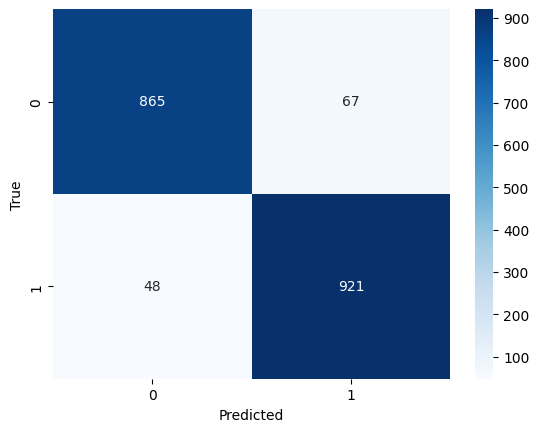

In [36]:
## Produce Visualised Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Pickle Model

In [37]:
pickle.dump(fit, open('logisticregression_model.pkl', 'wb'))
loaded_model = pickle.load(open('logisticregression_model.pkl', 'rb'))
loaded_model

LogisticRegression(C=18.74575432533948, max_iter=500)

### Testing the Model on unseen data
Using a section of a recent article from NBC news (https://www.nbcnews.com/politics/donald-trump/trump-sparks-republican-backlash-saying-immigrants-are-poisoning-blood-rcna130493). 

In [38]:
text = """"I think that that rhetoric is very inappropriate, but this administration’s policies are feeding right into it. And so I disagree with that. I think we should celebrate our diversity," said Rounds, who had endorsed Sen. Tim Scott, R-S.C., for president before he dropped out.

“But unfortunately, that type of rhetoric is what happens when you don’t have a border policy that works. And it just simply feeds that type of poor, unacceptable rhetoric,” he added.

Asked about the Republican criticism, Trump campaign spokesperson Steven Cheung said the former president "has by far the most Senate endorsements in this race, people who are fighters and want to Make America Great Again."

Trump's remarks took place at a speech in New Hampshire on Saturday, and he has since doubled down on them in a Truth Social post. """

In [39]:
## Prepare the text
text_lower = text.lower()
text = remove_punctuation(text_lower)
tokens = word_tokenize(text)
tokens = remove_stops(tokens, stops)
text_clean = ' '.join(tokens)

In [40]:
X_unlabeled = vectorizer.transform([text_clean])

In [41]:
labels = ['Real', 'Fake']
y_predict = loaded_model.predict(X_unlabeled)
probs = loaded_model.predict_proba(X_unlabeled)
print(f'Predicted class = {labels[y_predict[0]]}')
print(f'Probability of the article being real = {probs[0,y_predict[0]]}')

Predicted class = Real
Probability of the article being real = 0.9454743163170134
